<img
    style="border-radius: 0.5em;"
    src="https://ucfai.org/groups/core/fa19/rl/banner.png">

<div class="col-12">
    <h1> Training Machines to Learn From Experience </h1>
    <hr>
</div>

<div style="line-height: 2em;">
    <p>by: 
        <a href="https://ucfai.org/authors/danielzgsilva">@danielzgsilva</a>,
        <a href="https://ucfai.org/authors/jarviseq">@jarviseq</a> and,
        <a href="https://ucfai.org/authors/jmuchovej">@jmuchovej</a> on Nov 06, 2019</p>
</div>

In [ ]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input")
if (DATA_DIR / "ucfai-core-fa19-rl").exists():
    DATA_DIR /= "ucfai-core-fa19-rl"
elif DATA_DIR.exists():
    # no-op to keep the proper data path for Kaggle
    pass
else:
    # You'll need to download the data from Kaggle and place it in the `data/`
    #   directory beside this notebook.
    # The data should be here: https://kaggle.com/c/ucfai-core-fa19-rl/data
    DATA_DIR = Path("data")

We'll be using OpenAI's gym library and PyTorch for our reinforcement learning workshop. Naturally, we start off by importing these libraries, as well as a few others.

In [ ]:
import gym
from gym import wrappers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import io
import base64
from IPython.display import HTML
from tqdm import tqdm, trange

## OpenAI Gym - Mountain Car 

This is a classic reinforcement learning problem, in which our goal is to create an algorithm that enables a car to climb a steep mountain. 

A key point is that the car's engine is not powerful enough to drive directly up the mountain. Therefore, the car will need to utilize the left side mountain in order to gain enough momemtum to drive up the right side.

![Mountain Car](https://miro.medium.com/proxy/1*nbCSvWmyS_BUDz_WAJyKUw.gif)

In [ ]:
# Making our environment

env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)

## Details

In order to interact with OpenAI's gym environments, there are a few things we need to understand. 

Every environment has what's called an **action space**, or essentially the possible moves our car could make. We make these moves in steps. That is, choose an action, then apply that action, evaluate the results, and so on.

In [3]:
print(env.action_space)

Discrete(3)


As you can see, there are 3 distinct actions we can take at each step. These are: move left, stay still, or move right.

In practice, we apply one of these actions using **env.step()**

This action would then be applied to the car, resulting in a new **state**. In this Mountain Car example, the car's state is simply made up of its position and velocity. OpenAI likes to call this state an **observation**.

In [4]:
print(env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)

Box(2,)
[-1.2  -0.07]
[0.6  0.07]


As mentioned previously, the state, or an observation of the environment, consists of the car's position and velocity. This results in a length 2 observation space. The upper and lower bounds of this observation space signifies that the car's minimum and maximum position is -1.2 and 0.6, respectively. Position 0.5 and above signifies success. The cars min and max velocities are -0.7 and 0.7.

`env.step()` also returns a reward, based on the result of the action it received. The reward function for MountainCar is quite simple:
  For each step that the car does not reach the goal (position 0.5), the environment returns a reward of -1.

## Testing with Random Actions

We can now apply what we know about **gym** to see how Mountain Car would do with completely random actions. That is, at each step, we'll randomly select either move right, left, or neither. We'll play 1000 of these random Mountain Car games, each with an arbitrary number of 200 steps per game.

In [ ]:
# The car always begins 
max_position = -.4

# Array to track the further position the car got to in each game
positions = np.ndarray([0,2])

# We'll also track the total reward in each game, as well as which games were successful
rewards = []
successful = []

# Play 1000 MountainCar games
for episode in range(1000):
    running_reward = 0
    env.reset()

    # In each game, make 200 individual actions
    for i in range(200):
        # Take a random action
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)

        # Give reward for reaching a new maximum position
        current_position = state[0]
        if current_position > max_position:
            max_position = current_position
            positions = np.append(positions, [[episode, max_position]], axis=0)
            running_reward += 10
        else:
            running_reward += reward

        # Episode is done if we took our 200th step or if the cart reached the top of the hill
        if done: 

            # Document successful episode
            if current_position >= 0.5:
                successful.append(episode)
            
            # Document total reward for the episode
            rewards.append(running_reward)
            break

Furthest Position: -0.18254959181959152


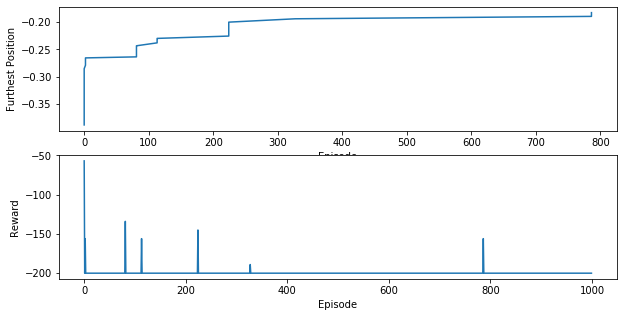

Successful Episodes: 0


In [6]:
print('Furthest Position: {}'.format(max_position))
plt.figure(1, figsize=[10,5])
plt.subplot(211)
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')
plt.subplot(212)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('Successful Episodes: {}'.format(np.count_nonzero(successful)))

We can see above that using random actions doesn't result in a single successful episode of Mountain Car, out of 1000 games.

## Q Learning Algorithm


We'll use Q-Learning, one of the most simple and common reinforcement learning algorithms, to learn a policy for our Mountain Car game. Intuitively, the policy we're learning is simply a function which decides what next action to take, given the cars current state, in order to maximize reward.

We'll represent this policy with a simple neural network with a single hidden layer. The network takes in the car's state (a length 2 vector of velocity and position) and outputs a length 3 action vector. In practice, we'd take the largest action in this array and apply it to the car.

In [ ]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 100

        # Create 2 fully connected layers

        # The first takes in the state and outputs 100 hidden nodes
        ### BEGIN SOLUTION
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        ### END SOLUTION
      
        # The second takes in the 100 hidden layers and outputs a length 3 action vector
        ### BEGIN SOLUTION
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
        ### END SOLUTION
    
    def forward(self, x):    
        # Feed the input, x, through each of the 2 layers we created
        ### BEGIN SOLUTION
        x = self.l1(x)
        x = self.l2(x)
        ### END SOLUTION
      
        return x

The Q-Learning algorithm will turn this Mountain Car problem into a supervised learning problem which our neural network will solve. In this case, $Q$ is essentially the estimated reward an agent would receive, given its current state, after taking a certain action. Everytime we take an action in the environment, we'll update $Q$ based on the reward returned for that state-action pair, as well as the maximum future action value one step in the future. 

![Q-Learning Algorithm](https://developer.ibm.com/developer/articles/cc-reinforcement-learning-train-software-agent/images/fig03.png)

The portion inside the brackets becomes the loss function for our neural network. Here, $Q(st, at)$ is the output of our network and $rt + \gamma\ \text{max}\ Q(st+1, at+1)$ is the target $Q$ value. The loss is then taken between $Q(st, at)$ and the calculated target $Q$ value. This turns the problem into a supervised learning problem solvable using gradient descent where $\alpha$ is our learning rate.

We'll run this algorithm on 2000 Mountain Car games, and in each game we take 2000 individual steps.

We also define a few parameters such as an epsilon value to be used when choosing the next action, as well as gamma and learning rate for the $Q$ function.

In [ ]:
# Parameters
episodes = 2000
steps = 2000
epsilon = 0.3
gamma = 0.99
max_position = -0.4
learning_rate = 0.001
state = env.reset()

In [ ]:
# Initialize the policy, loss function and optimizer
policy = Policy()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

loss_history = []
reward_history = []
position = []
successes = 0

At this point we're finally ready to train our policy using this Q-Learning algorithm.

In [10]:
# Run the Q-Learning algorithm on a number of Mountain Car episodes
for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()

    for s in range(steps):
        # Get first Q action value function
        Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        next_state, reward, done, _ = env.step(action)

        current_position = next_state[0]
        
        # Find the max Q action value for the next state
        Qs = policy(Variable(torch.from_numpy(next_state).type(torch.FloatTensor)))
        next_Q, _ = torch.max(Qs, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target.data)
        Q_target[action] = reward + torch.mul(next_Q.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy using gradient descent
        policy.zero_grad()
        loss.backward()
        optimizer.step()

        # Record history
        episode_loss += loss.item()
        episode_reward += reward

        # Keep track of max position
        if current_position > max_position:
            max_position = current_position
        
        if done:
            if current_position >= 0.5:
                # On successful epsisodes, adjust the following parameters

                # Adjust epsilon
                epsilon *= .99

                # Adjust learning rate
                scheduler.step()

                # Record successful episode
                successes += 1
            
            # Document loss, reward, and the car's current position
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
            position.append(current_position)

            break
        else:
            state = next_state
            
print('\n\nSuccessful Episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

100%|██████████| 2000/2000 [05:14<00:00,  5.13it/s]



Successful Episodes: 129 - 6.4500%


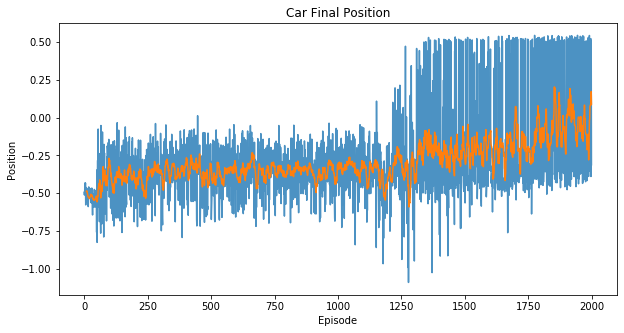

In [11]:
# Visualizing performance

plt.figure(2, figsize=[10,5])
p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

Running the Q-Learning algorithm on 2000 episodes of Mountain Car yields 129 successful episodes, or a 6.5% success rate. We can see that in the first 1000 or so episodes, the car seems to move a bit randomly at first. When the car finally reaches the goal for the first time, only then is it able to learn a policy which allows it to replicate this success. The car seems to then reach the goal about 30% of the time for the remaining 1000 episodes.

These results are certainly better than using totally random actions, but we could do much better. 

If you can recall, by default, the Mountain Car environment returns a reward of -1 for every step that did not result in success. Start thinking about possible shortcomings of this approach... Is there any information in the car's state that we could advantage of in order to create a better reward function?

## Visualizing the Policy

Now that we've trained a policy, let's take a second to visualize the decisions this policy is making. We can do so by plotting the policy's decisions for each possible combination of position and velocity.

In [ ]:
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    _, temp = torch.max(policy(Variable(torch.from_numpy(np.array([X[i],Y[i]]))).type(torch.FloatTensor)), dim =-1)
    z = temp.item()
    Z.append(z)
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

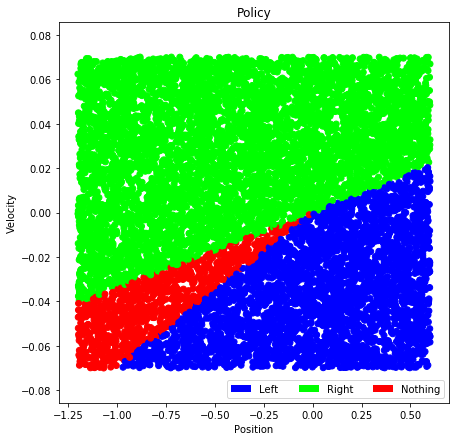

In [13]:
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

We can see that the policy decides to move the car left, *usually*, when the car is moving to the left (negative velocity), and then switches direction to the right when the car is moving to the right. 

This decision process allows the car to take advantage of momentum gained from the left hill. 

However, there seems to be a strange interaction between the car's position and the policy. It seems to favor moving right when the car is further to the left. This proves to be inefficient and inhibits the cars ability to utilize the left hill...

## Improving results

Let's think about why our current reward system might produce sub-optimal results... By default, the gym environment returns a reward of -1 for every step that doesn't result in success. This means the agent is not rewarded at all until it reaches the success point. Even if the car got close or made good progress in the problem, it's still negatively rewarded...

Because the reward stays constant throughout an episode, it is impossible for our policy to improve until the car randomly reaches the top. Earlier, this is why the policy required thousands of episodes before improving at all.

Now that we understand some of the shortcomings of our current reward system, let's attempt to design something better!



In [ ]:
# Re-making our environment

env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)

In [ ]:
# Resetting our parameters

# With an improved reward function, 1000 episodes with 200 steps/ep should be plenty to learn an effective policy.
episodes = 1000
steps = 200
epsilon = 0.3
gamma = 0.99
max_position = -0.4
learning_rate = 0.001
successes = 0
state = env.reset()

In [ ]:
# Re-Initialize Policy, loss function and optimizer
del policy

## BEGIN SOLUTION
policy = Policy()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
## END SOLUTION

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

loss_history = []
reward_history = []
position = []

Let's all spend a few minutes thinking about what changes or additions to the reward function might improve performance. Implement your ideas into the training block below and test it out!

**Hint:** We know that we're able to retrieve the car's position and velocity from the state object returned from the environment. I've already captured these in the code below (`current_position` and `current_velocity`). How could we use this information to improve the reward function? Could we reward the agent for at least moving in the right direction or getting close?

In [17]:
for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()

    for s in range(steps):
        # Get first action value function
        Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        next_state, reward, done, info = env.step(action)

        # You'll want to use these to improve the reward function. But how??
        current_position = next_state[0]
        current_velocity = next_state[1]
        
        # Make your adjustments or additions to the reward below
        ### BEGIN SOLUTION
        # Adjust reward based on car position
        reward = current_position + 0.5
        
        # Adjust reward for task completion
        if current_position >= 0.5:
            reward += 1
        ### END SOLUTION
        
        # Find max Q for t+1 state
        Qs = policy(Variable(torch.from_numpy(next_state).type(torch.FloatTensor)))
        next_Q, _ = torch.max(Qs, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target)
        Q_target[action] = reward + torch.mul(next_Q.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        policy.zero_grad()
        loss.backward()
        optimizer.step()

        episode_loss += loss.item()
        episode_reward += reward

        # Keep track of max position
        if current_position > max_position:
            max_position = current_position
        
        if done:
            if current_position >= 0.5:
                # On successful epsisodes, adjust the following parameters

                # Adjust epsilon
                epsilon *= .95

                # Adjust learning rate
                scheduler.step()
                optimizer.param_groups[0]['lr'] = max(optimizer.param_groups[0]['lr'], 1.0e-4)

                # Record successful episode
                successes += 1
            
            # Record history
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
            position.append(current_position)

            break
        else:
            state = next_state
            
print('\n\nSuccessful Episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

100%|██████████| 1000/1000 [02:20<00:00,  9.91it/s]



Successful Episodes: 721 - 72.1000%


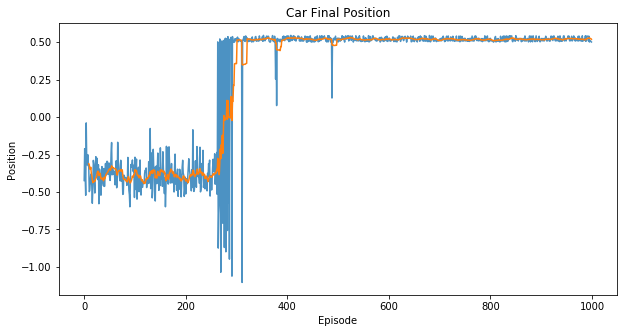

In [18]:
# Visualize your algorithms performance

plt.figure(2, figsize=[10,5])
p = pd.Series(position)
ma = p.rolling(10).mean()
plt.plot(p, alpha=0.8)
plt.plot(ma)
plt.xlabel('Episode')
plt.ylabel('Position')
plt.title('Car Final Position')
plt.show()

As you can see, this simple addition to the reward function results in a signicant improvement in performance. The car seems to learn an efficient policy in roughly 300 episodes, and is then able to achieve success in nearly every following episode.

![Solved Mountain Car](https://miro.medium.com/max/1202/0*VsDhkvrcaTOc2bwu.gif)

## Visualizing the Improved Policy

In [ ]:
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)
Z = []
for i in range(len(X)):
    _, Q = torch.max(policy(Variable(torch.from_numpy(np.array([X[i],Y[i]]))).type(torch.FloatTensor)), dim =-1)
    z = Q.item()
    Z.append(z)
Z = pd.Series(Z)
colors = {0:'blue',1:'lime',2:'red'}
colors = Z.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

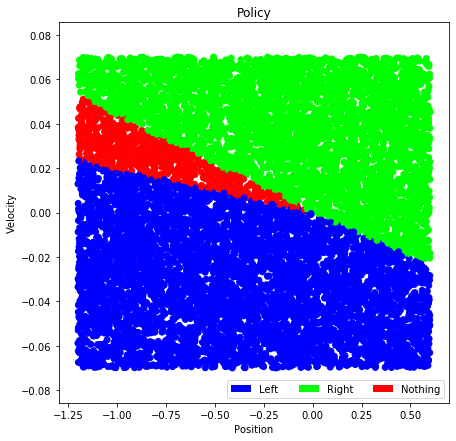

In [20]:
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=Z)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

With our improved reward function, the learned policy now seems to be more closely dependant on velocity. It decides to move left when the velocity is negative, and right when velocity is positive. As the results show, this is much more effective in solving MountainCar.

If you think about it, what this is doing is enabling the car to drive as far up a hill as possible. When momentum fades and the car begins to fall back down the mountain, our policy tells the engine to drive as fast as possible down this hill. After doing this enough times, the car's momentum will carry it over the large hill and past the flag.

![Solved Mountain Car](https://miro.medium.com/max/1202/0*VsDhkvrcaTOc2bwu.gif)


### Thank you for coming out tonight!
### Don't forget to sign in at ucfai.org/signin if you didn't get the chance to swipe in, and see you next week!